In [2]:
#load necessary packages and env code
%matplotlib inline

import gym
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import sys
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

from collections import defaultdict
from blackjack_fromgit import BlackjackEnv
from simple21 import Simple21

matplotlib.style.use('ggplot')

#examples from the web that I used to understand the question and devlop code from
#https://ernie55ernie.github.io/assets/blackjack.html
#https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/blackjack.py
#https://stackoverflow.com/questions/36589521/how-to-surface-plot-3d-plot-from-dataframe
#help from these sites and help from Data 643 classmates debugging code and understanding the prompts

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn


def get_epsilon(N):
    N_0 = 100
    return N_0/(N_0 + N)

def epsilon_greedy_policy(Q, N, state):
    player, dealer = state
    epsilon = get_epsilon(np.sum(N[player-1, dealer-1]))
    if np.random.rand() < (1 - epsilon):
        action = np.argmax(Q[player-1, dealer-1, :])
    else:
        action = np.random.choice([0,1])
    return action

def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
   
    returns_sum = np.zeros((21,10,2)) 
    returns_count = np.zeros((21,10,2))
    state_counts = np.zeros((21,10))

   
    Q = np.zeros((21,10,2))
    
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        while True:
            action = epsilon_greedy_policy(Q,state_counts,state)#policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            #state = (state[0] - 1,state[1] - 1)
            #sa_pair = (state, action)
            #sa_pair[0] = (sa_pair[0][0]-1, sa_pair[0][1] -1)
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])  #G is the expected reward
            # Calculate average return for this state over all sampled episodes
            state = (state[0] - 1,state[1] - 1)
            #sa_pair = (state, action)
            returns_sum[state][action] += G
            returns_count[state][action] += 1.0 #return_counts[state][action]
            state_counts[state] += 1.0
            Q[state][action] =+ (returns_sum[state][action] - Q[state][action]) / returns_count[state][action]
    
    return Q 

In [7]:
#helper function to plot the surface
def plottable_3d_info(df: pd.DataFrame):
    """
    Transform Pandas data into a format that's compatible with
    Matplotlib's surface and wireframe plotting.
    """
    index = df.index
    columns = df.columns

    x, y = np.meshgrid(np.arange(len(columns)), np.arange(len(index)))
    z = np.array([[df[c][i] for c in columns] for i in index])
    
    xticks = dict(ticks=np.arange(len(columns)), labels=columns)
    yticks = dict(ticks=np.arange(len(index)), labels=index)
    
    return x, y, z, xticks, yticks

In [4]:
#env = BlackjackEnv()
env = Simple21()

In [5]:
#run MC control for a given number of episodes
Q = mc_control_epsilon_greedy(env, num_episodes=50000, epsilon=0.1)

Episode 50000/50000.

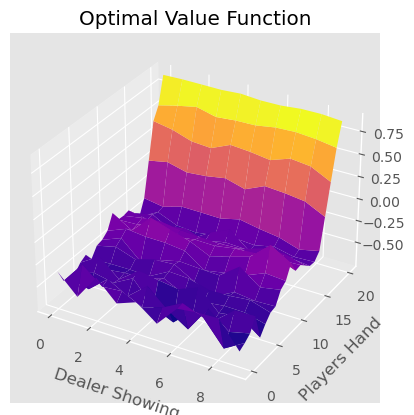

In [8]:
x, y, z, xticks, yticks = plottable_3d_info(pd.DataFrame(np.max(Q,2).T))

### Set up axes and put data on the surface.
fig = plt.figure()
axes = fig.add_subplot(projection='3d')
axes.plot_surface(y, x, z,cmap='plasma')
plt.xlabel('Dealer Showing')
plt.ylabel('Players Hand')
plt.title('Optimal Value Function')
plt.show()